In [81]:
import pandas as pd
import numpy as np

# Import data
crime_df = pd.read_excel('/Users/tamaraobando/Desktop/Crime_Prediction/MC_CrimeData.xlsx')



In [82]:
print(crime_df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 441532 entries, 0 to 441531
Data columns (total 30 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   Incident ID             441532 non-null  int64         
 1   Offence Code            441532 non-null  object        
 2   CR Number               441532 non-null  int64         
 3   Dispatch Date / Time    377775 non-null  datetime64[ns]
 4   Start_Date_Time         441532 non-null  datetime64[ns]
 5   End_Date_Time           201163 non-null  datetime64[ns]
 6   NIBRS Code              441532 non-null  object        
 7   Victims                 441532 non-null  int64         
 8   Crime Name1             441532 non-null  object        
 9   Crime Name2             441532 non-null  object        
 10  Crime Name3             441532 non-null  object        
 11  Police District Name    440258 non-null  object        
 12  Block Address           405963

In [83]:

# Filter data to include only incidents from 2020 to 2024
crime_df['Year'] = crime_df['Start_Date_Time'].dt.year
crime_df = crime_df[(crime_df['Year'] >= 2020) & (crime_df['Year'] <= 2024)]

# ONLY KEEP ROWS WHERE STATE == MD
crime_df = crime_df[crime_df['State'] == 'MD']

# Drop State column
crime_df = crime_df.drop(columns=['State'])

# Sort DataFrame by Start_Date_Time accending
crime_df = crime_df.sort_values(by='Start_Date_Time',ascending=True)



In [85]:
# Drop columns that are not needed for analysis

columns_to_keep = [
    'Start_Date_Time',  # for extracting date/time features
    'City',             # for spatial comparison
    'Zip Code',         # for geographic granularity
    'Crime Name1',      # for broad crime categories
    'Crime Name2',      # for crime subcategories
    'Latitude', 'Longitude',  # for heatmaps 
    'Victims',         # for victim count
    'Place',           # for location type
    'Agency',          # for exploring average response time for agency
    'Dispatch Date / Time'    
]

# Filter DataFrame to keep only the specified columns
crime_df = crime_df[columns_to_keep]



In [86]:
""" Standardize 'City' Column """



# Fix typos in 'City' column
city_fixes = {
    'GAITHERBURG': 'GAITHERSBURG',
    'BEHESDA': 'BETHESDA',
    'BEHTESDA': 'BETHESDA',
    'NORTH BETHESDA': 'BETHESDA',
    'CHEVY CAHSE': 'CHEVY CHASE',
    'BEALSVILLE': 'BEALLSVILLE',
    'BROOKVILLE': 'BROOKEVILLE',
    'SILVER': 'SILVER SPRING',
    'NORTH POTOMAC': 'POTOMAC',
    'Hyattsville Pg': 'Hyattsville',
}

crime_df['City'] = crime_df['City'].replace(city_fixes)
crime_df['City'] = crime_df['City'].str.strip().str.title()


# Identify and define list of cities in Montgomery County, Maryland
MOCO_cities = [
    'Rockville',
    'Silver Spring',
    'Gaithersburg',
    'Bethesda',
    'Potomac',
    'Montgomery Village',
    'Germantown',
    'North Bethesda',
    'Chevy Chase',
    'Clarksburg',
    'Takoma Park',
    'Wheaton',
    'Olney',
    'Poolesville',
    'Kensington',
    'Laytonsville',
    'Derwood',
    'Aspen Hill',
    'Damascus',
    'Burtonsville',
    'Cabin John',
    'Washington Grove',
    'Glen Echo',
    'Garrett Park',
    'Darnestown',
    'Colesville',
]

# Keep rows if 'City' is in the MOCO_cities list
crime_df = crime_df[crime_df['City'].isin(MOCO_cities)]


In [87]:
# Check for missing values in 'Zip Code' column
crime_df=crime_df.dropna()

# Convert 'Zip Code' to string data type
crime_df['Zip Code'] = crime_df['Zip Code'].astype(np.int64).astype('string')

# Identify and define list of zip codes in Montgomery County, Maryland
MOCO_zips = [
    "20707", "20777", "20812", "20814", "20815", "20816", "20817", "20818",
    "20832", "20833", "20837", "20838", "20839", "20841", "20842", "20850",
    "20851", "20852", "20853", "20854", "20855", "20860", "20861", "20862",
    "20866", "20868", "20871", "20872", "20874", "20876", "20877", "20878",
    "20879", "20882", "20886", "20889", "20892", "20894", "20895", "20899",
    "20901", "20902", "20903", "20904", "20905", "20906", "20910", "20912",
    "21771", "21797"
]


# Keep rows if 'Zip Code' is in the MOCO_zips list
crime_df = crime_df[crime_df['Zip Code'].isin(MOCO_zips)]




In [96]:
""" Clean up 'Place' names """

## Group similar 'Place' categories 

# Reclassify to 'Office Building'
crime_df['Place'] = crime_df['Place'].replace('Commercial - Office Building', 'Office Building')

# Reclassify to 'Lodging'
crime_df['Place'] = crime_df['Place'].replace('Hotel/Motel/Etc.', 'Lodging')

# Reclassify to 'Religious Facility'
crime_df['Place'] = crime_df['Place'].replace('Church/Synagogue/Temple', 'Religious Facility')

# Reclassify to 'Homeless Shelter'
crime_df['Place'] = crime_df['Place'].replace('Shelter-Mission/Homeless', 'Homeless Shelter')

# Group all residential-related places into the category 'Residential'
crime_df.loc[crime_df['Place'].str.contains('resid|residence', case=False, na=False), 'Place'] = 'Residential'

# Group all school-related places into the category 'School'
crime_df.loc[crime_df['Place'].str.contains('School', case=False, na=False), 'Place'] = 'School'

# Group all liquor-related places into the category 'Liquor Store'
crime_df.loc[crime_df['Place'].str.contains('Liquor', case=False, na=False), 'Place']= 'Liquor Store'

# Group all auto-related places into the category 'Auto Services'
crime_df.loc[crime_df['Place'].str.contains('Auto', case=False, na=False), 'Place']= 'Auto Services'


# Identifty and define list of medical-related places
medical_places = [
    'Hospital/Emergency Care Center',
    'Doctor/Dentist/Vet Office'
]

# Replace them with 'Medical Facility'
crime_df.loc[crime_df['Place'].isin(medical_places), 'Place'] = 'Medical Facility'

# Identifty and define list of financial-related places



# Identifty and define list of child care-related places
child_care = [
    'Daycare Facility',
    'Nursery'
]

# Replace them with 'Child Care Center'
crime_df.loc[crime_df['Place'].isin(child_care), 'Place'] = 'Child Care Center'


# Identifty and define list of industrial-related places
construction_industrial = [
    'Industrial Site',
    'Construction Site',
    'Commercial - Industrial park',
    'Dock/Wharf/Freight/Modal Terminal'
]

# Replace them with 'Construction/Industrial Sites'
crime_df.loc[crime_df['Place'].isin(construction_industrial), 'Place'] = 'Industrial Site'

# Identifty and define list of public transportation-related places
public_transportation = [
    'Pedestrian Tunnel',
    'Air/Bus/Train/Metro Terminal',
    'Street - Bus Stop'
]

# Replace them with 'public_transportation'
crime_df.loc[crime_df['Place'].isin(public_transportation), 'Place'] = 'Public Transportation'


# Identifty and define list of entertainment-related places
entertainment = [
    'Arena/Stadium/Fairgrounds/Coliseum',
    'Theater',
    'Amusement Park',
    'Golf Course',
    'Gambling Facility / Casino / Race Track'
]

# Replace them with 'Entertainment Venue'
crime_df.loc[crime_df['Place'].isin(entertainment), 'Place'] = 'Entertainment Venue'

# Identifty and define list of nature-related places
nature_area = [
    'Field/ Open Space',
    'Wooded Area',
    'Lake/Waterway',
    'Park',
    'Camp / Campground'
]

# Replace them with 'Nature Area'
crime_df.loc[crime_df['Place'].isin(nature_area), 'Place'] = 'Natural Area'


# Identifty and define list of street-related places
street = [
    'Street - Alley',
    'Street - Other',
    'Street - Bus Stop',
    'Street - Commercial',
    'Street - In vehicle'
]

# Replace them with 'Street'
crime_df.loc[crime_df['Place'].isin(street), 'Place'] = 'Street'

# Identify and define list of retail-related places
retail = [
    'Retail - Department/Discount Store',
    'Retail - Drug Store/Pharmacy',
    'Retail - Other',
    'Retail - Mall',
    'Retail - Clothing',
    'Retail - Hardware',
    'Retail - Sporting Goods',
    'Retail - Appliances/Electronics',
    'Retail - Salon/Spa',
    'Retail - Beauty/Barber Shop',
    'Retail - Jewelry',
    'Retail - Dry Cleaner',
    'Retail - Video Store'  
]

# Replace them with 'Retail'
crime_df.loc[crime_df['Place'].isin(retail), 'Place'] = 'Retail'

# Identify and define list of parking-related places
parking = [
    'Parking Lot - Commercial',
    'Parking Lot - Other',
    'Parking Garage - Commercial',
    'Parking Garage - County',
    'Parking Lot - County',
    'Parking Garage - Other',
    'Parking Lot - Rec Center',
    'Parking Lot - Park & Ride',
    'Parking Lot - Church',
    'Parking Garage - Metro',
    'Parking Lot - Metro'  
]

# Replace them with 'Parking Area'
crime_df.loc[crime_df['Place'].isin(parking), 'Place'] = 'Parking Area'



In [89]:
""" Feature Engineering """

#Create new columns for date/time features 
crime_df['Year'] = crime_df['Start_Date_Time'].dt.year
crime_df['Month'] = crime_df['Start_Date_Time'].dt.month
crime_df['Month_Name'] = crime_df['Start_Date_Time'].dt.strftime('%B')
crime_df['DayOfWeek'] = crime_df['Start_Date_Time'].dt.day_name()
crime_df['Hour'] = crime_df['Start_Date_Time'].dt.hour

# Create new columns for season
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

crime_df['Season'] = crime_df['Month'].apply(get_season)

# Create new columns for time of day
def get_time_of_day(hour):
    if 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    elif 18 <= hour < 24:
        return 'Evening'
    else:
        return 'Night'

crime_df['TimeOfDay'] = crime_df['Hour'].apply(get_time_of_day)

# Create new columns for weekend/weekday
crime_df['Is_Weekend'] = crime_df['DayOfWeek'].isin(['Saturday', 'Sunday'])






Top 5 Specific Crime Types: ['Theft From Motor Vehicle', 'Simple Assault', 'Shoplifting', 'Destruction/Damage/Vandalism of Property', 'All other Larceny']

 Analyzing: Theft From Motor Vehicle
Kruskal-Wallis statistic = 5.46, p = 0.1408
➡️ No significant seasonal difference


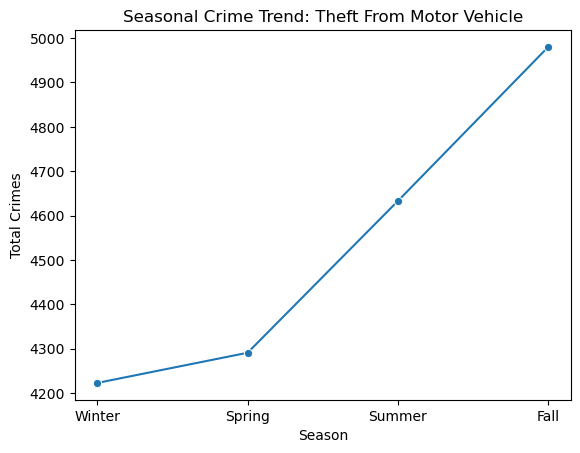


 Analyzing: Simple Assault
Kruskal-Wallis statistic = 2.71, p = 0.4384
➡️ No significant seasonal difference


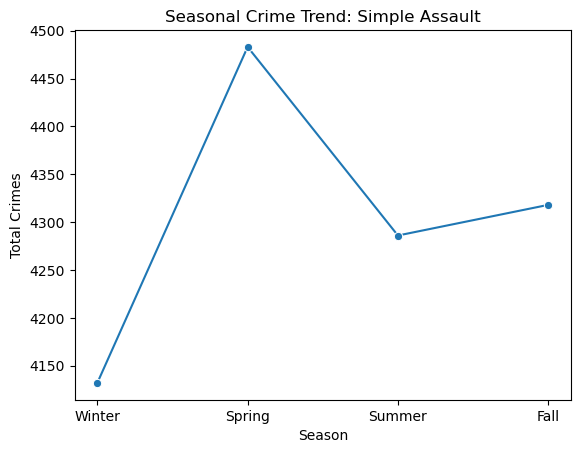


 Analyzing: Shoplifting
Kruskal-Wallis statistic = 0.37, p = 0.9466
➡️ No significant seasonal difference


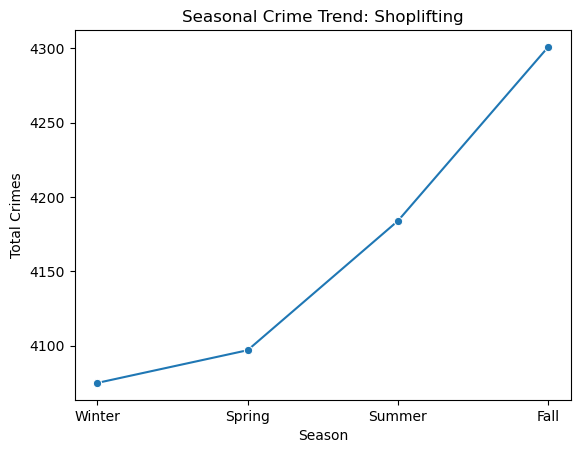


 Analyzing: Destruction/Damage/Vandalism of Property
Kruskal-Wallis statistic = 17.72, p = 0.0005
➡️ Significant difference across seasons


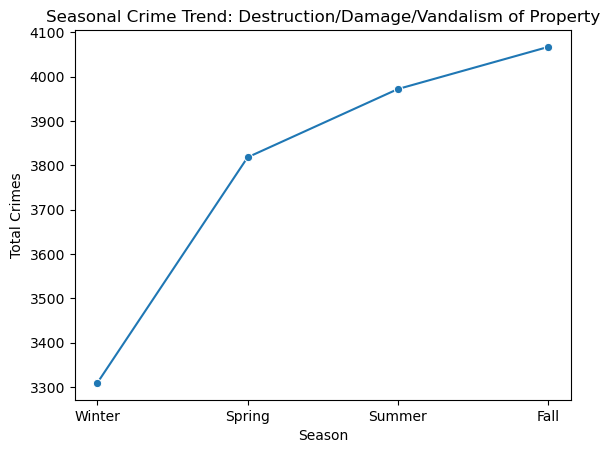


 Analyzing: All other Larceny
Kruskal-Wallis statistic = 9.51, p = 0.0233
➡️ Significant difference across seasons


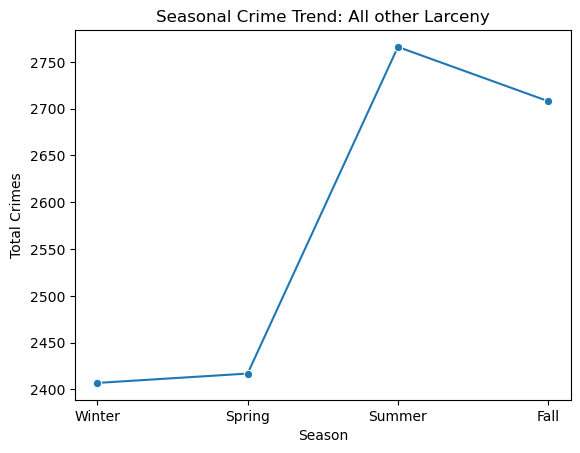

In [100]:

""" Testing for Seasonal Crime Trends """

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import kruskal



# Get the top 5 specific crime types (excluding "All Other Offenses")
top_5_crimes = (
    crime_df[crime_df['Crime Name2'] != 'All Other Offenses']
    ['Crime Name2']
    .value_counts()
    .head(5)
    .index
    .tolist()
)

print("Top 5 Specific Crime Types:", top_5_crimes)


# Ensure your date column is datetime and Season exists
crime_df['YearMonth'] = crime_df['Start_Date_Time'].dt.to_period('M')

# Loop through top 5 crimes
for crime in top_5_crimes:
    print(f"\n Analyzing: {crime}")
    
    # Filter for specific crime
    crime_subset = crime_df[crime_df['Crime Name2'] == crime]
    
    # Group by season + month for testing
    grouped = (
        crime_subset
        .groupby(['Season', 'YearMonth'])
        .size()
        .reset_index(name='Crime_Count')
    )

    # Separate by season
    winter = grouped[grouped['Season'] == 'Winter']['Crime_Count']
    spring = grouped[grouped['Season'] == 'Spring']['Crime_Count']
    summer = grouped[grouped['Season'] == 'Summer']['Crime_Count']
    fall   = grouped[grouped['Season'] == 'Fall']['Crime_Count']
    
    # Run Kruskal-Wallis test
    result = kruskal(winter, spring, summer, fall)
    print(f"Kruskal-Wallis statistic = {result.statistic:.2f}, p = {result.pvalue:.4f}")
    
    # Interpret result
    if result.pvalue < 0.05:
        print("➡️ Significant difference across seasons")
    else:
        print("➡️ No significant seasonal difference")

    # Plot seasonal totals
    season_plot = (
        crime_subset
        .groupby('Season')
        .size()
        .reset_index(name='Total_Crimes')
        .sort_values(by='Season', key=lambda x: x.map({'Winter':0, 'Spring':1, 'Summer':2, 'Fall':3}))
    )

    sns.lineplot(data=season_plot, x='Season', y='Total_Crimes', marker='o')
    plt.title(f'Seasonal Crime Trend: {crime}')
    plt.ylabel('Total Crimes')
    plt.show()





<Figure size 1400x600 with 0 Axes>

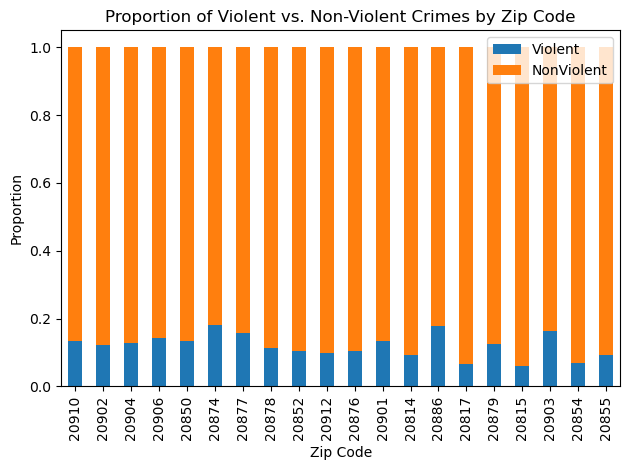

Gini for Violent Crimes: 0.5863
Gini for Non-Violent Crimes: 0.5376


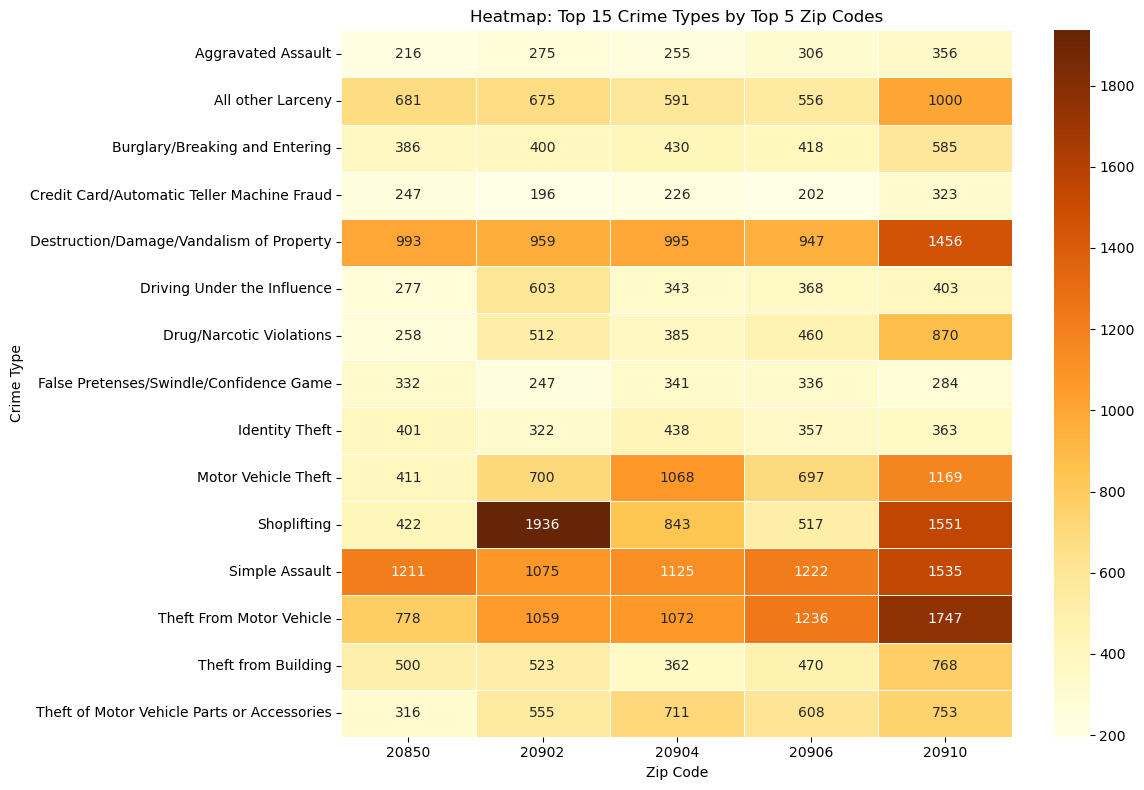

In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


""" Violent Crime Distribution by Zip Code """


# Define violent crime types
violent_crimes = [
    'Simple Assault', 'Aggravated Assault', 'Robbery',
    'Murder and Nonnegligent Manslaughter', 'Forcible Rape', 
    'Forcible Fondling', 'Kidnapping/Abduction'
]

# Label violent crimes
crime_df['Violent'] = crime_df['Crime Name2'].isin(violent_crimes)

# Drop rows with missing Zip Code
zip_crime = crime_df.dropna(subset=['Zip Code'])

# Group by Zip Code and Violent/NonViolent count
zip_counts = (
    zip_crime
    .groupby(['Zip Code', 'Violent'])
    .size()
    .unstack(fill_value=0)
    .rename(columns={True: 'Violent', False: 'NonViolent'})
)

# Compute total and proportions
zip_counts['Total'] = zip_counts['Violent'] + zip_counts['NonViolent']
zip_counts = zip_counts.sort_values(by='Total', ascending=False)

# limit to top 20 zip codes
top_zips = zip_counts.head(20)

# Normalize for comparison
zip_counts_percent = top_zips[['Violent', 'NonViolent']].div(top_zips['Total'], axis=0)

# Plot stacked bar chart
plt.figure(figsize=(14, 6))
zip_counts_percent.plot(kind='bar', stacked=True, color=['#1f77b4', '#ff7f0e'])
plt.title("Proportion of Violent vs. Non-Violent Crimes by Zip Code")
plt.xlabel("Zip Code")
plt.ylabel("Proportion")
plt.legend(["Violent", "NonViolent"])
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Gini coefficient function
def gini(array):
    """Compute Gini coefficient."""
    array = np.sort(array)
    n = len(array)
    cumulative = np.cumsum(array)
    return (n + 1 - 2 * np.sum(cumulative) / cumulative[-1]) / n

# Compute and print Gini for both crime types
gini_violent = gini(zip_counts['Violent'].values)
gini_nonviolent = gini(zip_counts['NonViolent'].values)

print(f"Gini for Violent Crimes: {gini_violent:.4f}")
print(f"Gini for Non-Violent Crimes: {gini_nonviolent:.4f}")

# Heatmap Visualization 

# Get top 15 crime types (excluding “All Other Offenses”)
top_crimes = (
    crime_df[crime_df['Crime Name2'] != 'All Other Offenses']
    ['Crime Name2'].value_counts().head(15).index
)

# Get top 5 zip codes by crime volume
top_5_zips = zip_counts.head(5).index

# Filter dataset
filtered_df = crime_df[
    (crime_df['Crime Name2'].isin(top_crimes)) &
    (crime_df['Zip Code'].isin(top_5_zips))
]

# Crosstab: Crime Type vs. Zip Code
zip_crime_heatmap = pd.crosstab(
    filtered_df['Crime Name2'],
    filtered_df['Zip Code']
)

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(zip_crime_heatmap, cmap='YlOrBr', linewidths=0.5, annot=True, fmt='d')
plt.title('Heatmap: Top 15 Crime Types by Top 5 Zip Codes')
plt.xlabel('Zip Code')
plt.ylabel('Crime Type')
plt.tight_layout()
plt.show()


Mann-Whitney U statistic: 2482828885.50
p-value: 0.0035


/var/folders/pz/t6sh438s5_q461hngv848s500000gn/T/ipykernel_2966/2964249158.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Is_Weekend', y='Crime Count', data=daily_counts, palette='Set2')


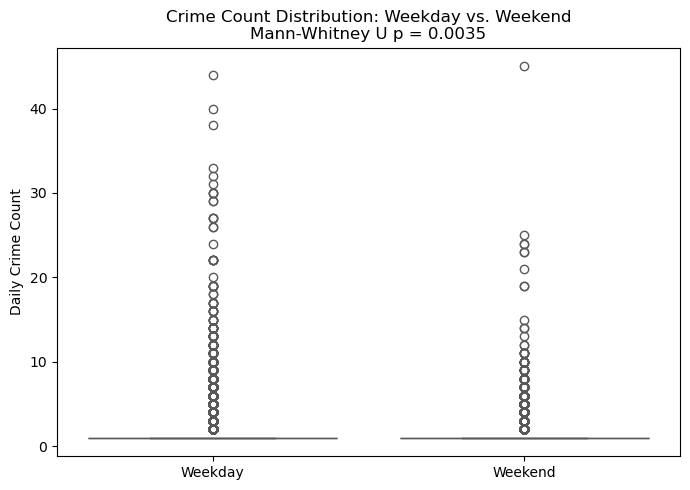

In [125]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu

# Ensure datetime
crime_df['Start_Date_Time'] = pd.to_datetime(crime_df['Start_Date_Time'])

# Daily crime counts
daily_counts = crime_df.groupby(['Start_Date_Time', 'Is_Weekend']).size().reset_index(name='Crime Count')

# Mann-Whitney U Test
weekend_counts = daily_counts[daily_counts['Is_Weekend']]['Crime Count']
weekday_counts = daily_counts[~daily_counts['Is_Weekend']]['Crime Count']
u_stat, p_val = mannwhitneyu(weekend_counts, weekday_counts, alternative='two-sided')

# Print test result
print(f"Mann-Whitney U statistic: {u_stat:.2f}")
print(f"p-value: {p_val:.4f}")

# Boxplot
plt.figure(figsize=(7, 5))
sns.boxplot(x='Is_Weekend', y='Crime Count', data=daily_counts, palette='Set2')
plt.xticks([0, 1], ['Weekday', 'Weekend'])
plt.title(f'Crime Count Distribution: Weekday vs. Weekend\nMann-Whitney U p = {p_val:.4f}')
plt.ylabel('Daily Crime Count')
plt.xlabel('')
plt.tight_layout()
plt.show()
